# Edge Project: Time Series Analysis and Feature Extraction


### The purpose of this notebook is to explain and show how the process of time series feature extraction was carried out. Extracting features from the time series data is vital as it can potentially give us more information to be paired with the tabular data that we already have access to. However, it is important to note that only about 25% of the subjects/children that are present in the tabular data were given a wrist-worn acceleromter in this time series data. The time series data for this project only includes the information/data that is tracked by these wrist-worn accelerometers, which can be thought of as a similar device to something like a fitbit or apple watch.

### This file mostly focuses on one example of this time series data for a subject/child. We perform some preliminary exploratory data analysis(EDA) to get an understanding of the data and make some potential inferences as to what features may be important. We then extract time series features using the "tsfresh" library. For the example parquet file we use for EDA, we should not that this specific file actually has no missing values. However, the extraction and imputation are applied to all parquet files with the useful functions defined towards the end of this document. 

## **Instructions for use**:

### In order to use and run this notebook, please first download the necessary data, which can be found at [Child Mind Institute Problematic Internet Use Competition - Kaggle](https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/data?select=series_train.parquet)

### When running this notebook, ensure that the files are saved to the proper directory.


In [ ]:
# Install necessary packages if needed.
!pip install fancyimpute
!pip install tsfresh
!pip install fastparquet
!pip install pyarrow
!pip install soft_impute


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement soft_impute (from versions: none)
ERROR: No matching distribution found for soft_impute

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import plotly.express as plx
import plotly.subplots as sbp
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.graph_objects as go
import numpy as np
from scipy.fftpack import fft
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import find_peaks
from statsmodels.tsa.stattools import acf
from fancyimpute import SoftImpute

#This package is important for extracting time series information
from tsfresh import extract_features

import fastparquet as fp
import pyarrow as parr
import os

## Understanding the Time Series Data:

Some participants were given wearable accelerometers to wear for up to 30 days. However, only certain subjects were given these accelerometers, and the amount of days for which subjects wore them is sparse. However, there is a variable names `non-wear_flag` that indicates whether or not a subject was wearing a accelerometers.



## Let's look into **one** parquet file first.

In [3]:
df_parquet_1 = pd.read_parquet('child_mind_parquet_files/series_train.parquet/id=0a418b57/part-0.parquet', engine='pyarrow')


In [4]:
df_parquet_1.head()

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
0,0,-0.075242,-0.256743,-0.973791,0.038081,-72.952141,0.0,5.0,4202.000000,51250000000000,2,4,-9.0
1,1,-0.265893,-0.270508,-0.765470,0.077430,-52.849220,0.0,0.5,4185.333496,51255000000000,2,4,-9.0
2,2,0.334517,-0.548602,-0.588596,0.039162,-44.118084,0.0,11.5,4185.500000,51260000000000,2,4,-9.0
3,3,0.000193,-0.021069,-0.999681,0.001450,-88.759613,0.0,0.0,4185.666504,51265000000000,2,4,-9.0
4,4,-0.000685,-0.020681,-0.997677,0.000491,-88.756958,0.0,8.5,4185.833496,51270000000000,2,4,-9.0


In [5]:
# value counts for non-wear flag
df_parquet_1['non-wear_flag'].value_counts()

non-wear_flag
0.0    213423
Name: count, dtype: int64

## Let's break down what the features in the time series mean:

* `id` - The patient identifier corresponding to the id field in train/test.csv.
step - An integer timestep for each observation within a series.
* `X`, `Y`, `Z`- Measure of acceleration, in g, experienced by the wrist-worn watch along each standard axis.
* `enmo` - As calculated and described by the wristpy package, ENMO is the Euclidean Norm Minus One of all accelerometer signals (along each of the x-, y-, and z-axis, measured in g-force) with negative values rounded to zero. Zero values are indicative of periods of no motion. While no standard measure of acceleration exists in this space, this is one of the several commonly computed features.
* `anglez` - As calculated and described by the wristpy package, Angle-Z is a metric derived from individual accelerometer components and refers to the angle of the arm relative to the horizontal plane.
* `non-wear_flag` - A flag (0: watch is being worn, 1: the watch is not worn) to help determine periods when the watch has been removed, based on the GGIR definition, which uses the standard deviation and range of the accelerometer data.
* `light` - Measure of ambient light in lux. See ​​here for details.
* `battery_voltage` - A measure of the battery voltage in mV.
* `time_of_day` - Time of day representing the start of a 5s window that the data has been sampled over, with format %H:%M:%S.%9f.
* `weekday` - The day of the week, coded as an integer with 1 being Monday and 7 being Sunday.
* `quarter` - The quarter of the year, an integer from 1 to 4.
* `relative_date_PCIAT` - The number of days (integer) since the PCIAT test was administered (negative days indicate that the actigraphy data has been collected before the test was administered).

## Beginning with EDA on this time series data

In [6]:
print(df_parquet_1.describe())

                step              X              Y              Z  \
count  213423.000000  213423.000000  213423.000000  213423.000000   
mean   106711.000000       0.195960       0.175270      -0.258108   
std     61610.057588       0.539906       0.510206       0.453659   
min         0.000000      -2.156349      -2.749820      -1.224756   
25%     53355.500000      -0.215934      -0.144534      -0.609729   
50%    106711.000000       0.304541       0.197180      -0.292209   
75%    160066.500000       0.644210       0.586222       0.023711   
max    213422.000000       1.648549       3.055914       1.992976   

                enmo         anglez  non-wear_flag          light  \
count  213423.000000  213423.000000       213423.0  213423.000000   
mean        0.056785     -17.940048            0.0      34.272129   
std         0.138671      31.710234            0.0     161.993332   
min         0.000000     -89.846779            0.0       0.000000   
25%         0.006549     -39.8415

In [7]:
print(df_parquet_1.isnull().sum())
#There is no missing data in this specific file.

step                   0
X                      0
Y                      0
Z                      0
enmo                   0
anglez                 0
non-wear_flag          0
light                  0
battery_voltage        0
time_of_day            0
weekday                0
quarter                0
relative_date_PCIAT    0
dtype: int64


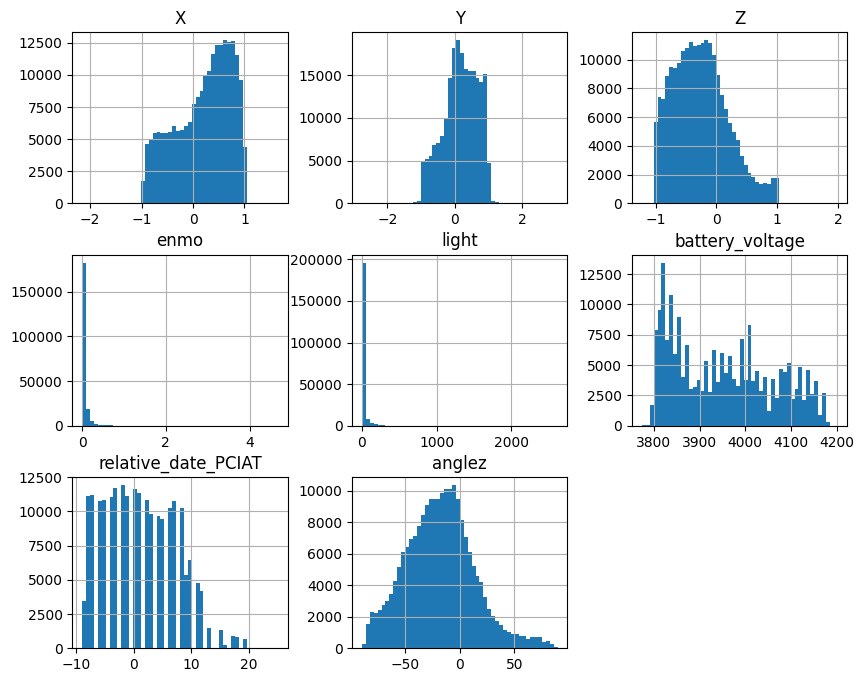

In [8]:
#Histograms
df_parquet_1[['X', 'Y', 'Z', 'enmo', 'light', 'battery_voltage', 'relative_date_PCIAT', 'anglez']].hist(bins=50, figsize=(10, 8))
plt.show()

## Some comments on the features included in the histograms above:
* `X`, `Y`, `Z`: We can notice from the features in this time series that we get some negative values for X,Y,Z features, which are measures of acceleration. This is expected as subjects can move in different directions. There is not much importat information from these variables.

* `enmo`: we can see from the histogram for enmo, which refers to the euclidean norm (l2 norm) minus one of all accelerometer signals along each x,y,z axis that that this distribution is strongly right-skewed. In the context of this data, this indicates that most of the observations occur when this individual has an enmo value of 0, which means that they were NOT in motion. Perhaps this can help provide us with an important notion of the subject's activity level, which can consequently help us make inferences about the overall physical and mental health of the individual. These inferences may provide us with importat information about the subject's `ssi` as less time spent being active may be related to more time spent using the internet, which may have an effect on a subject's level of problematic internet use.

* `light`: the distribution for light for this individual is strongly right-skewed with a large bulk of the data occurring at `light` values of 0. Recall that this is a measure of ambient light in *lux*. According to documentation from "ActiGraph", ambient light "may affect subject sleeping habits ," (ActiGraph). However, we must also consider that in the context of this problem, the amount of light exposre that a subject gets may alsobe related to their activity level. Empirically, exposre to sunlight and the outdoors is healthy and may pertain to outdoor physical activities. The histogram in this case that has most of the observations at low values for light indicates that the subject was exposed to light comparable to the following settings according to ActiGraph's interpretation of the lux level:
    * Twilight (Lux Level 1)
    * Minimal street lighting (Lux Level 5)
    * Sunset (Lux Level 10)
    * Family Living Room (Lux Level 50)
    * Hallway (Lux Level 80)
    * Very Dark Overcast Day (Lux Level 100)
    * Office Lighting (Lux Level 320 - 500)
    We can see from the histogram for this individual that the observed values for light are between 0 and about 400; however, according to our summary statistics the maximum light value observed was about 2622.600098. Nonetheless, this light value of  about 2622.60 is still far less than ActiGraph's interpretation of "Full Daylight" which corresponds to 10,000 - 25,000. These observations may indicate that the individual in this case was not exposed to much light when they were wearing the accelerometer. Furthermore, it could very well be the case that these observations were taken when the individual was asleep; however, we can investigate this further by looking into the `time_of_day` variable.

* `battery_voltage`: we can see from the histogram of this feature that there is right skewed distribution, which indicates that this specific subject was wearing the accelerometer mostly when the battery voltage was on the lower end of the possible ranges of mV (mega volts).

* `relative_date_PCIAT`: This distribution is somewhat skewed to the right. We can note that this variable pertains to the number of days since the PCIAT test was administered to a subject. Recall that PCIAT is a questionnaire wih a 20-item scale that measures behaviors associated with compulsive use of the internet. This questionnaire is self-reported and designed for parents to report about their child's internet usage using a likert scale to answer questions with the followign responses available:

    * N/A or Rarely
    * Occasionally
    * Frequently
    * Often
    * Always

From this domain knowledge regarding the PCIAT test, one can note that typically parents do not want to report undesriable metrics regarding their children's internet usage. Not only that, but the data is self-reported and self-assessed, so there is inherent bias introduced in this case. Therfefore, this may be an indicator as to why there are more observations earlier on in the trial when parents may be hyper aware of the potential issues that they were recently called upon to think about.

### Implications of Observations
There are a series of implications with this data and the observations we make from the histograms of the selection of features. Namely, we have not specifically explored the time at which these observations are made, and it can be the case that many of these observations are taken when the subject is asleep. Furthermore, dealing with data observations that come from a human subject is inherently difficult, and humans behavior and habits are very difficult to predict and track because they have free will. Not only that, but when evaluating light, it is important to noote that the light is detected by the wearable device, so if the subject is wearing clothes that cover the wrist-worn accelerometer, this may effect the light levels that are detected.

## Investigating the `time_of_day` variable

In [9]:
df_parquet_1['time_of_day'].head()

0    51250000000000
1    51255000000000
2    51260000000000
3    51265000000000
4    51270000000000
Name: time_of_day, dtype: int64

### An initial look at this `time_of_day` variable indicates that this is an integer variable. However, it appears that this variable calculates the number of nano seconds that have elapsed since midnight. However, we aim to see a more parsed breakdown of this variable.

In [10]:
# convert to timedelta object:
df_parquet_1['time_of_day'] = pd.to_timedelta(df_parquet_1['time_of_day'], unit='ns')

# make this variable more interpretable
df_parquet_1['time_of_day_parsed'] = df_parquet_1['time_of_day'].astype(str)

df_parquet_1

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT,time_of_day_parsed
0,0,-0.075242,-0.256743,-0.973791,0.038081,-72.952141,0.0,5.0,4202.000000,0 days 14:14:10,2,4,-9.0,0 days 14:14:10
1,1,-0.265893,-0.270508,-0.765470,0.077430,-52.849220,0.0,0.5,4185.333496,0 days 14:14:15,2,4,-9.0,0 days 14:14:15
2,2,0.334517,-0.548602,-0.588596,0.039162,-44.118084,0.0,11.5,4185.500000,0 days 14:14:20,2,4,-9.0,0 days 14:14:20
3,3,0.000193,-0.021069,-0.999681,0.001450,-88.759613,0.0,0.0,4185.666504,0 days 14:14:25,2,4,-9.0,0 days 14:14:25
4,4,-0.000685,-0.020681,-0.997677,0.000491,-88.756958,0.0,8.5,4185.833496,0 days 14:14:30,2,4,-9.0,0 days 14:14:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213418,213418,0.391111,0.658119,-0.511350,0.060158,-35.455124,0.0,22.0,3817.430664,0 days 10:45:45,1,4,25.0,0 days 10:45:45
213419,213419,0.551039,0.078267,-0.787324,0.094029,-52.621586,0.0,22.0,3817.430664,0 days 10:45:50,1,4,25.0,0 days 10:45:50
213420,213420,0.667007,-0.126560,-0.751950,0.013104,-47.961002,0.0,22.0,3817.430664,0 days 10:50:15,1,4,25.0,0 days 10:50:15
213421,213421,0.666465,-0.125810,-0.749048,0.010495,-47.928806,0.0,22.0,3817.430664,0 days 10:50:20,1,4,25.0,0 days 10:50:20


### Now, we have a more readable variable for the `time_of_day`; however, we aim to focus on the hour for analysis.


In [11]:
df_parquet_1['time_of_day_parsed']
df_parquet_1['time_of_day_parsed'] = pd.to_timedelta(df_parquet_1['time_of_day_parsed'])

## Extract the hours from this variable

       time_of_day_parsed  hour
0         0 days 14:14:10    14
1         0 days 14:14:15    14
2         0 days 14:14:20    14
3         0 days 14:14:25    14
4         0 days 14:14:30    14
...                   ...   ...
213418    0 days 10:45:45    10
213419    0 days 10:45:50    10
213420    0 days 10:50:15    10
213421    0 days 10:50:20    10
213422    0 days 10:50:25    10

[213423 rows x 2 columns]


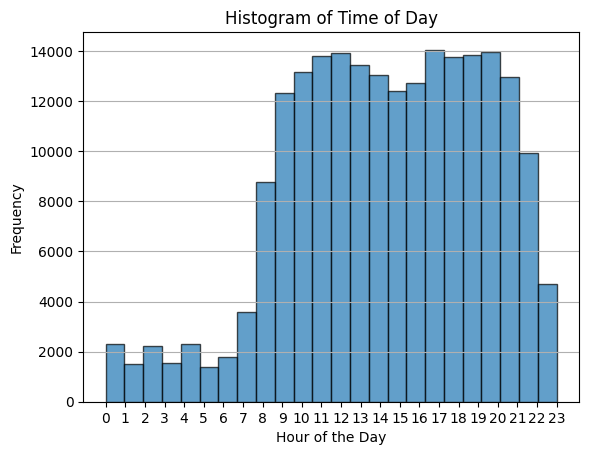

In [12]:
# Extracting Hour
df_parquet_1['hour'] = df_parquet_1['time_of_day_parsed'].dt.seconds // 3600


print(df_parquet_1[['time_of_day_parsed', 'hour']])

plt.hist(df_parquet_1['hour'], bins=24, edgecolor='k', alpha=0.7)  # One bin per hour
plt.title('Histogram of Time of Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.xticks(range(24)) 
plt.grid(axis='y')
plt.show()

Here, we revisualize the matrix of histograms and now we include the time of day variable where we break it down at the hourly grain.

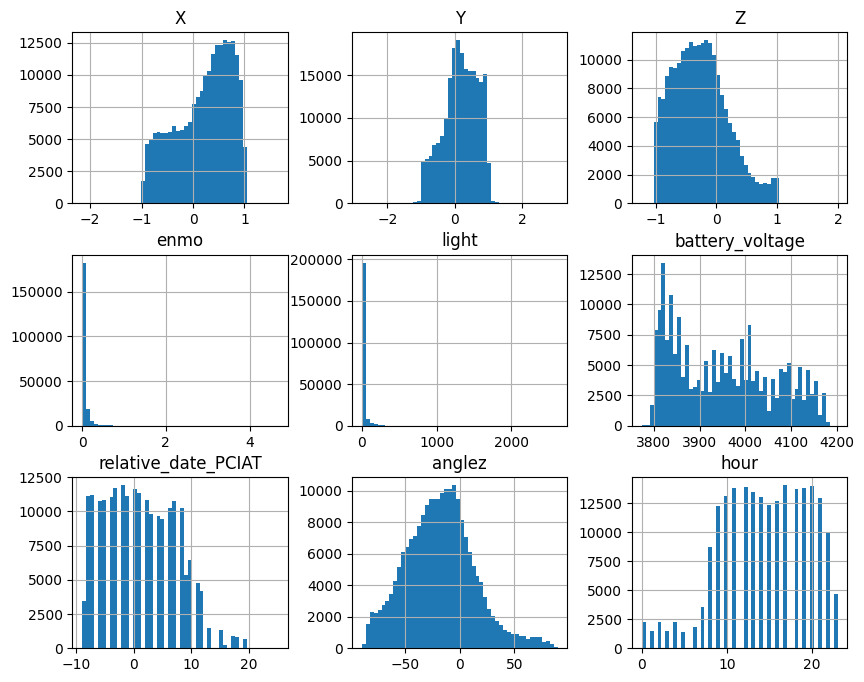

In [13]:
df_parquet_1[['X', 'Y', 'Z', 'enmo', 'light', 'battery_voltage', 'relative_date_PCIAT', 'anglez', 'hour']].hist(bins=50, figsize=(10, 8))
plt.show()

# After some preliminary EDA on the time series data, we managerially decide on some potential variables of interest:

* `enmo`: this variable can potentially give an indication of the level of movement of a given child or teen throughout the day. If there is limited or no movement during the night, but there is some movement during the day, this could be indicative of healthy behaviors that may give insight into unhealthy internet usage.

* `light`: the variable that measures light in *lux* may provide important insights into whether a child or teen is exposed to light at a given time. Namely, an example of then usefullness of this variable can be used in conjunction with the time variables. When there is high light exposure at night, this could be indiciative of poor sleeping habits, and potentially problematic use of the internet.

* `time_of_day` and `hour`: this variable is vital to understanding the two previously mentioned variables in the time series data that is being assessed.

* `relative_date_PCIAT`: this variable is important as it can provide insight into potential behavioral changes based on the time of the PCIAT test. As we recount earlier, the nature of this test may understandably cause behaviorial shifts following it's administration as people may be more hyper aware of their potentially negative habits.

## Here, we aim to do some preliminary feature extraction using summary statistics. This section is mostly included to display our learning process as we explore the process of extracting features from time series data.

In [14]:
summary_features = df_parquet_1.agg({
    'X': ['mean', 'std', 'min', 'max', 'median'],
    'Y': ['mean', 'std', 'min', 'max', 'median'],
    'Z': ['mean', 'std', 'min', 'max', 'median'],
    'enmo': ['mean', 'std', 'min', 'max', 'median'],
    'anglez': ['mean', 'std', 'min', 'max', 'median'],
    'light': ['mean', 'std', 'min', 'max', 'median'],
    'battery_voltage': ['mean', 'std', 'min', 'max', 'median'],
    'relative_date_PCIAT': ['mean', 'std', 'min', 'max', 'median'],

})
summary_features = summary_features.unstack().to_dict()

summary_features


{('X', 'mean'): 0.19596002995967865,
 ('X', 'std'): 0.5399056077003479,
 ('X', 'min'): -2.1563494205474854,
 ('X', 'max'): 1.6485493183135986,
 ('X', 'median'): 0.30454128980636597,
 ('Y', 'mean'): 0.17526963353157043,
 ('Y', 'std'): 0.5102064609527588,
 ('Y', 'min'): -2.7498202323913574,
 ('Y', 'max'): 3.0559139251708984,
 ('Y', 'median'): 0.1971803605556488,
 ('Z', 'mean'): -0.2581079304218292,
 ('Z', 'std'): 0.4536593556404114,
 ('Z', 'min'): -1.2247560024261475,
 ('Z', 'max'): 1.9929758310317993,
 ('Z', 'median'): -0.2922087609767914,
 ('enmo', 'mean'): 0.056784626096487045,
 ('enmo', 'std'): 0.13867053389549255,
 ('enmo', 'min'): 0.0,
 ('enmo', 'max'): 4.674657821655273,
 ('enmo', 'median'): 0.018648209050297737,
 ('anglez', 'mean'): -17.940048217773438,
 ('anglez', 'std'): 31.710233688354492,
 ('anglez', 'min'): -89.8467788696289,
 ('anglez', 'max'): 89.840576171875,
 ('anglez', 'median'): -18.342580795288086,
 ('light', 'mean'): 34.27212905883789,
 ('light', 'std'): 161.99333190

### Here, we get a better idea of how much movement/activity is tracked through the course of the day by averaging movement per hour.

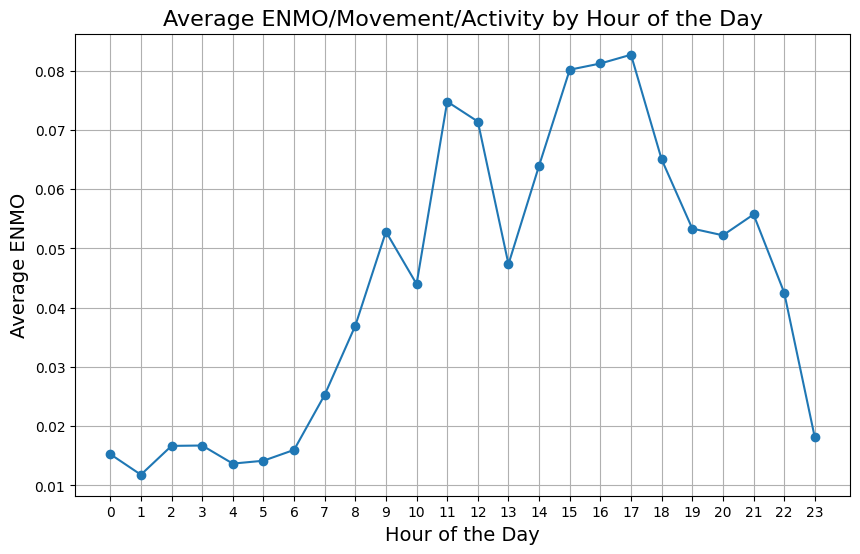

In [15]:
# How miuch movement/activity is tracked through the course of the day:
hourly_activity = df_parquet_1.groupby('hour')['enmo'].mean()
hourly_activity

# Plot ENMO against hour
plt.figure(figsize=(10, 6))
plt.plot(hourly_activity.index, hourly_activity.values, marker='o')
plt.title('Average ENMO/Movement/Activity by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Average ENMO', fontsize=14)
plt.xticks(range(24))  # Ensure all hours are displayed
plt.grid(True)
plt.show()


### We can see here that the average movement of this specific observation tends to peak at around 11am and then again at around 5pm. The behavior of the plot indicates that the observation in question tends to wake up at around 7am, is fairly active throughout the day, and then begins to wind down for the night at around 10pm. This behavior is indicative of what we will consider for the scope of this project a "normal" schedule.

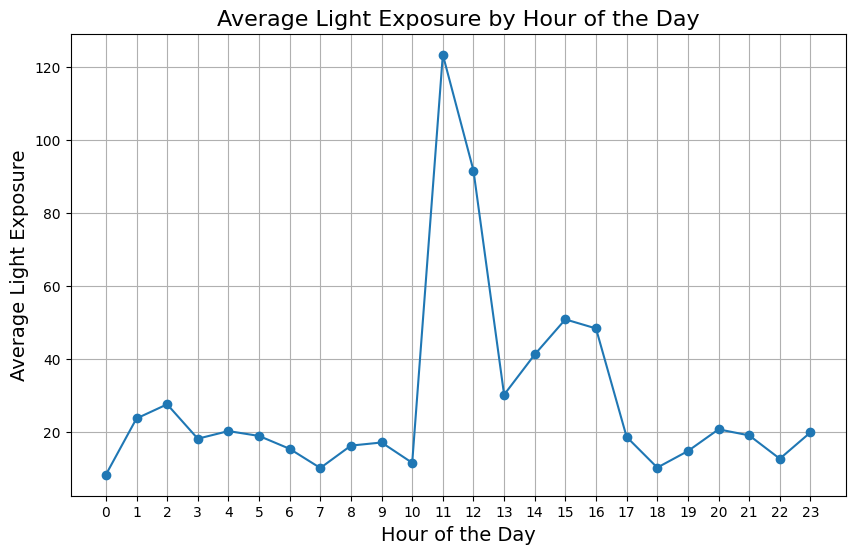

In [16]:
#How much light is the child exposed to throughout the day
hourly_light = df_parquet_1.groupby('hour')['light'].mean()
hourly_light

# Plot light against hour
plt.figure(figsize=(10,6))
plt.plot(hourly_light.index, hourly_light.values, marker='o')
plt.title('Average Light Exposure by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Average Light Exposure', fontsize=14)
plt.xticks(range(24))  # Ensure all hours are displayed
plt.grid(True)
plt.show()


### According to the plot here, we can see that the specific child appears to be exposed to the most light during middle of the day. It follows that there is a peak in light exposure in the morning; however, later in the day it follows that light exposure is lower as the child may be asleep.


In [25]:
avg_movement_date = df_parquet_1.groupby('relative_date_PCIAT')['enmo'].mean().reset_index()
print(avg_movement_date.head())

   relative_date_PCIAT      enmo
0                 -9.0  0.049982
1                 -8.0  0.056056
2                 -7.0  0.044742
3                 -6.0  0.029232
4                 -5.0  0.074848


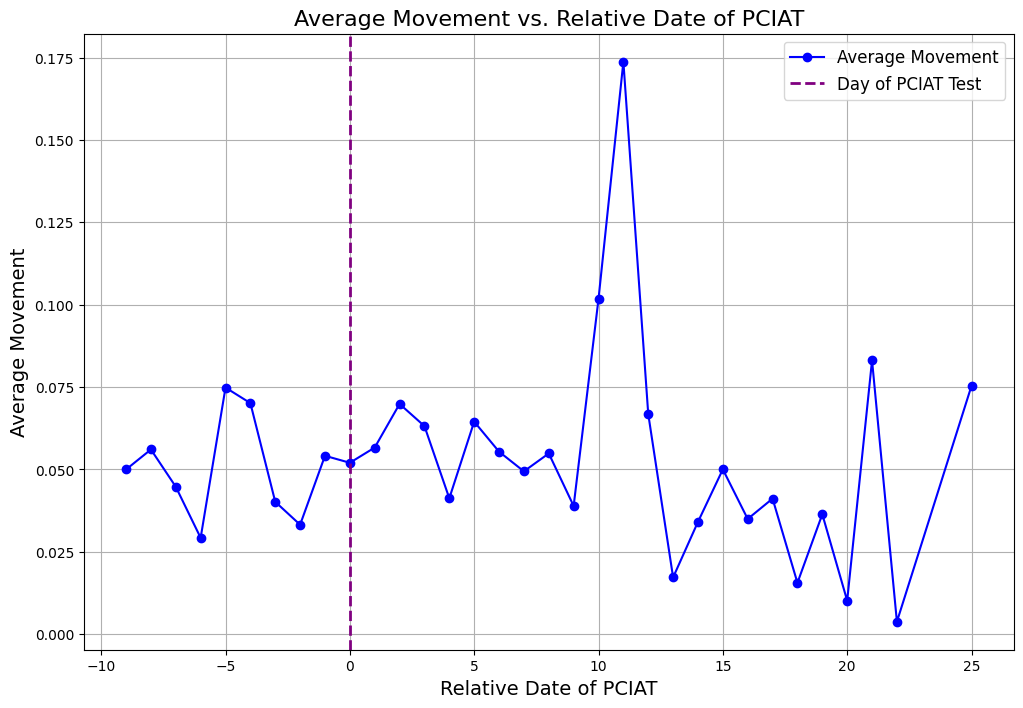

In [26]:

# Plot the average movement against the relative date of PCIAT
plt.figure(figsize=(12, 8))
plt.plot(avg_movement_date['relative_date_PCIAT'], avg_movement_date['enmo'], marker='o', linestyle='-', color='blue', label='Average Movement')

# Add a vertical line at `relative_date_PCIAT = 0`
plt.axvline(x=0, color='purple', linestyle='--', linewidth=2, label='Day of PCIAT Test')

# Customize plot labels and title
plt.title('Average Movement vs. Relative Date of PCIAT', fontsize=16)
plt.xlabel('Relative Date of PCIAT', fontsize=14)
plt.ylabel('Average Movement', fontsize=14)

# Add a legend
plt.legend(fontsize=12)

# Display the grid
plt.grid(True)

# Show the plot
plt.show()

### ### According to the plot above, recall that the relative date of PCIAT refers to the number of days since the PCIAT test was administered to a subject. Note that negative values for this feature indicate that some data was collected before the test was administered, so in this case, the subject had been wearing the monitor prior to the day of the PCIAT test. According to this plot, we can see that this specific individual has a peak for average movement at about 11 days after taking the PCIAT test. It seems from this plot that the average movement for this child begins to decrease after about 10 days post the PCIAT test was administered.

In [23]:
avg_light_date = df_parquet_1.groupby('relative_date_PCIAT')['light'].mean().reset_index()
print(avg_light_date.head())

   relative_date_PCIAT      light
0                 -9.0  24.884903
1                 -8.0  14.491158
2                 -7.0   6.648375
3                 -6.0   7.185634
4                 -5.0  64.773468


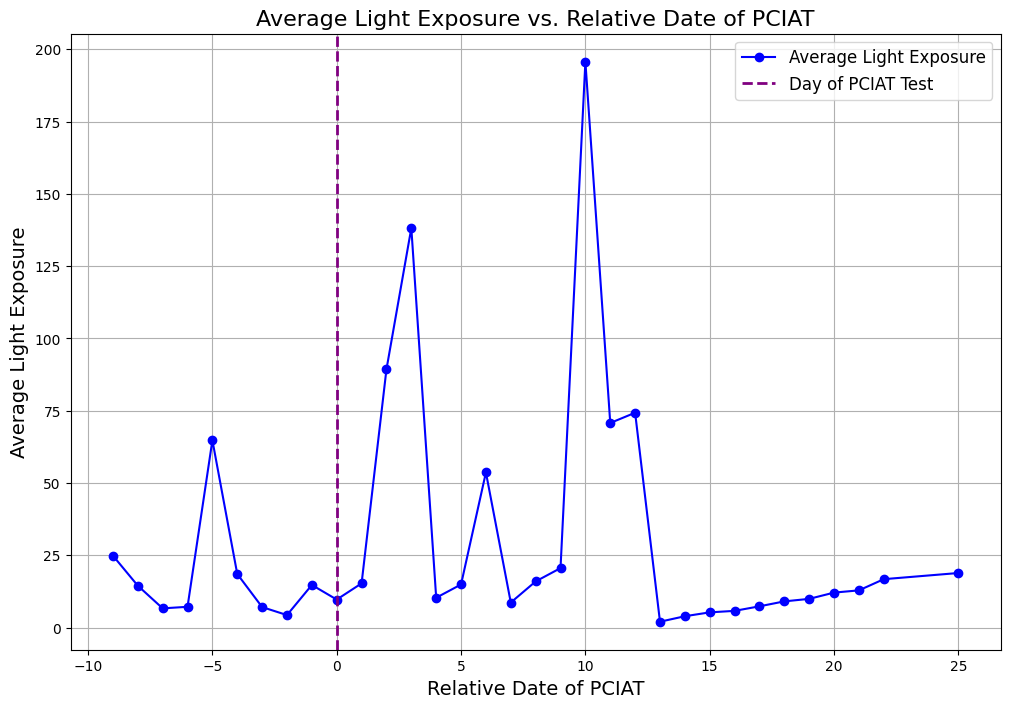

In [24]:

# Plot the average light exposure
plt.figure(figsize=(12, 8))
plt.plot(avg_light_date['relative_date_PCIAT'], avg_light_date['light'], marker='o', linestyle='-', color='blue', label='Average Light Exposure')

# Add a vertical line at `relative_date_PCIAT = 0`
plt.axvline(x=0, color='purple', linestyle='--', linewidth=2, label='Day of PCIAT Test')

# Customize plot labels and title
plt.title('Average Light Exposure vs. Relative Date of PCIAT', fontsize=16)
plt.xlabel('Relative Date of PCIAT', fontsize=14)
plt.ylabel('Average Light Exposure', fontsize=14)

# Add a legend
plt.legend(fontsize=12)

# Display the grid
plt.grid(True)

# Show the plot
plt.show()


### According to the plot above, recall that the relative date of PCIAT refers to the number of days since the PCIAT test was administered to a subject. Note that negative values for this feature indicate that some data was collected before the test was administered, so in this case, the subject had been wearing the monitor prior to the day of the PCIAT test. We can notice that in the 10 days after the test is administered, the subject tends to get a higher amount of average light exposure. This could potentially insinuate that after the test was administered, the subject or the parent of the subject could have potentially been more aware of problematic behaviors that the PCIAT test could have highlighted. Again, recall that the PCIAT test is a 20-item scale that measures behaviors and tendencies of subjects that may be associated with problematic internet usage. 

### This plot is important to consider as it is potentially correlated to the plot that we see for the average movement as we observe a peak at around 10-11 days after the PCIAT test is taken. We might infer that when this child is more exposed to light throughout the day, they may have also been outside being active for example. 

### Overall, these plots give some insight into the potential usefullness of the time series data.

# We now move into more advanced feature extraction techniques and we aim to leverage tools from `tsfresh` for feature extraction.

In [ ]:
# First we reload our data
df_parquet_1 = pd.read_parquet('child_mind_parquet_files/series_train.parquet/id=0a418b57/part-0.parquet', engine='pyarrow')

## Using `tsfresh`


### In the following functions, we move away from our analysis of one single parquet file. Recall that one parquet file refers to one child/subject in the data set. The first function immediately after this markdown chunk, will use the child id, which pertains to the name of the parquet file that contains the time series data in question.

### The following function leverages two main uses:

* We use SoftImpute to fill potential missing values in the time series data for `light` as well as for `enmo`, which are the two most important features we aim to glean insights from and then connect to our tabular data.

* We also use tsfresh to extract these features from the time series data. Note that the argument "MinimalFCParameters" includes a smaller subset of features and is an ideal way to handle large amounts of data when undergoing feature extraction. ACcording to the tsfresh official documentation, this dictionary is mainly implemented to reduce the computational expense of feature extraction across multiple large datasets. In our case, this feature extraction is ultimately performed for nearly 1000 separate individuals that all include time series data for up to 30 days. 


In [ ]:
#function to extract features using tsfresh
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters
from fancyimpute import SoftImpute
import pandas as pd
import numpy as np
from tsfresh.feature_extraction import MinimalFCParameters

# Define a function for data preparation and feature extraction
def extract_tsfresh_features(ts_df, kid_id, wake_time=6):
    """
    Extract features using tsfresh with imputation and time binning.
    """
    # Step 1: Data Preparation
    ts_df = ts_df.copy()
    ts_df["hour"] = np.floor(ts_df["time_of_day"] / 1000000000 / 60 / 60)  # Add hour column
    ts_df["day"] = ts_df["time_of_day"] // (24 * 60 * 60 * 1000000000)  # Daily bins
    
    #If there are missing values for enmo and light throughout various different time series, we impute them.
    ts_df[["enmo", "light"]] = SoftImpute().fit_transform(ts_df[["enmo", "light"]])
    
    # Step 2: Feature Extraction
    # Define the features to extract
    feature_columns = ["enmo", "light", "hour", "weekday", "relative_date_PCIAT"]
    ts_fresh_df = ts_df[["time_of_day"] + feature_columns]
    ts_fresh_df.rename(columns={"time_of_day": "step"}, inplace=True)

    # Dummy id
    ts_fresh_df["id"] = 0

    # Determine n_jobs to be used when extracting
    n_jobs = os.cpu_count() or 1  # Default to 1 if os.cpu_count() is None

    # Use tsfresh to extract features
    extracted_features = extract_features(
        ts_fresh_df,
        column_id= "id",          # Group by 'id' (daily bins)
        column_sort="step",      # Sort by 'step' within each group
        default_fc_parameters=MinimalFCParameters(),  # Use a feature set that includes 
        n_jobs=n_jobs,               # Use all available cores
        disable_progressbar=False
    )

    # Ensure that 'id' is a column
    extracted_features.reset_index(inplace=True)
    
    # Step 3: Add Aggregates for Specific Metrics
    # Recreate custom metrics like peak movement/light hours
    peak_movement_hour = ts_df.groupby("hour")["enmo"].sum().idxmax()
    peak_light_hour = ts_df.groupby("hour")["light"].sum().idxmax()
    
    # Collect additional summary statistics
    avg_movement_day = ts_df[ts_df["hour"] >= wake_time]["enmo"].mean()
    avg_movement_night = ts_df[ts_df["hour"] < wake_time]["enmo"].mean()

    # Combine tsfresh and custom metrics into a single DataFrame
    custom_metrics = {
        "kid_id": kid_id,
        "peak_movement_hour": peak_movement_hour,
        "peak_light_hour": peak_light_hour,
        "avg_movement_day": avg_movement_day,
        "avg_movement_night": avg_movement_night,
    }
    custom_metrics_df = pd.DataFrame([custom_metrics])

    
    # Merge extracted features and custom metrics
    final_features = pd.concat([extracted_features.reset_index(drop=True), custom_metrics_df], axis=1)
    return final_features


In [ ]:
# Apply the function to one file as a test.
result = extract_tsfresh_features(ts_df=df_parquet_1, kid_id="0a418b57", wake_time=6)
print(result.head())

In [ ]:
# Optional: Save the result to a csv file
#result.to_csv('extracted_features_train_0a418b57.csv')

In [ ]:
# Define a function for data preparation and feature extraction
# def extract_tsfresh_features(ts_df, kid_id, wake_time=6):
#     """
#     Extract features using tsfresh with imputation and time binning.
#     """
#     # Step 1: Data Preparation
#     ts_df = ts_df.copy()
#     ts_df["hour"] = np.floor(ts_df["time_of_day"] / 1000000000 / 60 / 60)  # Add hour column
#     ts_df["day"] = ts_df["time_of_day"] // (24 * 60 * 60 * 1000000000)  # Daily bins
    
#     # Impute missing values (e.g., enmo, light)
#     ts_df[["enmo", "light"]] = SoftImpute().fit_transform(ts_df[["enmo", "light"]])
    
#     # Step 2: Feature Extraction
#     # Define the features to extract
#     feature_columns = ["enmo", "light", "hour", "weekday", "relative_date_PCIAT"]
#     ts_fresh_df = ts_df[["time_of_day"] + feature_columns]
#     ts_fresh_df.rename(columns={"time_of_day": "step"}, inplace=True)

#     # Dummy id
#     ts_fresh_df["id"] = 0

#     # Determine n_jobs to be used when extracting
#     n_jobs = os.cpu_count() or 1  # Default to 1 if os.cpu_count() is None

#     # print number of missing values
#     print(ts_fresh_df.isnull().sum())

#     return final_features

# Rolling this up to all the parquet files available that contain time series data:

### Now that we have confirmed that we can use feature extraction via "tsfresh", we aim to extract features from all the time series data that each subject/child may have when it is available. All of the parquet files for the training set of data are stored in a directory called `series_train.parquet`. We use this directory to find all the parquet files that contain the time series data, and we then loop through all of the directories, obtain the id of the subject/child, and save their extracted time series feature to a .csv that is to be joined with the tabular data.

In [ ]:
# Define the parent directory
parent_dir = "child_mind_parquet_files/series_train.parquet"

# Define a function to process all participants
def process_all_participants(parent_dir, output_file="all_participant_ts_features.csv"):
    if not os.path.exists(output_file):
        pd.DataFrame().to_csv(output_file, index=False)
    
    # Loop through all subdirectories (participant folders)
    for subdir in os.listdir(parent_dir):
        participant_dir = os.path.join(parent_dir, subdir)
        participant_id = subdir.split("=")[-1]  # Extract ID from folder name

        # Check if the "part-0.parquet" file exists in this directory
        file_path = os.path.join(participant_dir, "part-0.parquet")
        if os.path.isfile(file_path):
            try:
                # Read the parquet file
                ts_df = pd.read_parquet(file_path)
                
                # Process this participant's file using the function
                result = extract_tsfresh_features(ts_df, kid_id=participant_id, wake_time=6)
                
                # Save the result directly to the output file
                result.to_csv(output_file, mode="a", index=False, header=not os.path.exists(output_file))
                print(f"Processed {participant_id} and saved results.")
            except Exception as e:
                print(f"Error processing {participant_id}: {e}")
    

## **WARNING**: We highly reccommend NOT running the code chunk below unless you have a very powerful chip. The loop does take a bit of time to run and saves files directly to your directory.

## After the loop completes, we obtain extracted and imputed time series features for each child who was given a wrist-worn accelerometer that tracked fitness data in the form of motion and light exposure mostly. Again, teach time series in each of these files is a continuous recording of this accelerometer data for a single subject spanninng for up to 30 days. The output is a .csv file that includes these extracted features for each subject/child.

### We then repeat this process for the test set.

In [ ]:
# Define the parent directory
parent_dir_test = "child_mind_parquet_files/series_test.parquet"

# Define a function to process all participants
def process_all_participants(parent_dir_test, output_file="all_participant_ts_features_test.csv"):
    if not os.path.exists(output_file):
        pd.DataFrame().to_csv(output_file, index=False)
    
    # Loop through all subdirectories (participant folders)
    for subdir in os.listdir(parent_dir_test):
        participant_dir = os.path.join(parent_dir_test, subdir)
        participant_id = subdir.split("=")[-1]  # Extract ID from folder name

        # Check if the "part-0.parquet" file exists in this directory
        file_path = os.path.join(participant_dir, "part-0.parquet")
        if os.path.isfile(file_path):
            try:
                # Read the parquet file
                ts_df = pd.read_parquet(file_path)
                
                # Process this participant's file using the function
                result = extract_tsfresh_features(ts_df, kid_id=participant_id, wake_time=6)
                
                # Save the result directly to the output file
                result.to_csv(output_file, mode="a", index=False, header=not os.path.exists(output_file))
                print(f"Processed {participant_id} and saved results.")
            except Exception as e:
                print(f"Error processing {participant_id}: {e}")

In [ ]:
# Run the function and process all participants
process_all_participants(parent_dir_test)

# Function for extracting **managerially defined features of interest**:

In [9]:
def extract_custom_metrics(ts_df, kid_id, wake_time=6):
    """
    Extracts the following features:
    - Peak movement and light hours during the whole day
    - Summary statistics for movement during the day
    - Summary statistics for movement during the night
    - Summary statistics for light during the day
    - Summary statistics for light during the night
    - Non-wear rate
    - Summary statistics the 10, 30, and 60 minutes of maximum movement during the whole day.

    """

    # Add hour of the day for the measurement
    ts_df["hour"] = np.floor(ts_df["time_of_day"] / 1000000000 / 60 / 60)

    # Peak movement hour
    peak_movement_hour = ts_df.groupby("hour")["enmo"].sum().idxmax()

    # Peak light hour
    peak_light_hour = ts_df.groupby("hour")["light"].sum().idxmax()

    # Define subsets for daytime and nighttime
    daytime_df = ts_df[~((ts_df["hour"] <= wake_time) & (ts_df["hour"] >= 0))]
    nighttime_df = ts_df[((ts_df["hour"] <= wake_time) & (ts_df["hour"] >= 0))]

    # Movement during waking hours
    avg_movement_day = daytime_df["enmo"].mean()
    max_movement_day = daytime_df["enmo"].max()
    min_movement_day = daytime_df["enmo"].min()
    median_movement_day = daytime_df["enmo"].median()
    std_movement_day = daytime_df["enmo"].std()
    range_movement_day = max_movement_day - min_movement_day

    # Movement during sleep hours
    avg_movement_night = nighttime_df["enmo"].mean()
    max_movement_night = nighttime_df["enmo"].max()
    min_movement_night = nighttime_df["enmo"].min()
    median_movement_night = nighttime_df["enmo"].median()
    std_movement_night = nighttime_df["enmo"].std()
    range_movement_night = max_movement_night - min_movement_night

    # Light during waking hours
    avg_light_day = daytime_df["light"].mean()
    max_light_day = daytime_df["light"].max()
    min_light_day = daytime_df["light"].min()
    median_light_day = daytime_df["light"].median()
    std_light_day = daytime_df["light"].std()
    range_light_day = max_light_day - min_light_day


    # Light during sleep hours
    avg_light_night = nighttime_df["light"].mean()
    max_light_night = nighttime_df["light"].max()
    min_light_night = nighttime_df["light"].min()
    median_light_night = nighttime_df["light"].median()
    std_light_night = nighttime_df["light"].std()
    range_light_night = max_light_night - min_light_night

    # non-wear-rate (people who can't stick to wearing this might have worse habits)
    non_wear_rate = len(ts_df[ts_df["non-wear_flag"] >= 0.7]) / len(ts_df)

    # There is 1 measurement every 5 seconds
    # 12 rows per minute
    # 360 rows in half an hour

    # Max 30 minutes of average movement during the day
    def find_max_enmo_avg(group, minutes=30):
        """Gets the maximum movement rolling average"""

        window = minutes*12
        group['rolling_avg'] = group['enmo'].rolling(window=window, min_periods=window).mean()

        return group['rolling_avg'].max()

    max_avg_movement_10min = ts_df.groupby('relative_date_PCIAT').apply(find_max_enmo_avg, minutes=10)
    max_avg_movement_30min = ts_df.groupby('relative_date_PCIAT').apply(find_max_enmo_avg)
    max_avg_movement_60min = ts_df.groupby('relative_date_PCIAT').apply(find_max_enmo_avg, minutes=60)

    result_dict = {
        "id": kid_id,
        # "peak_movement_hour": peak_movement_hour,
        # "peak_light_hour": peak_light_hour,
        
        # Daytime movement statistics
        # "avg_movement_day": avg_movement_day,
        "max_movement_day": max_movement_day,
        "min_movement_day": min_movement_day,
        "median_movement_day": median_movement_day,
        "std_movement_day": std_movement_day,
        "range_movement_day": range_movement_day,
        
        # Nighttime movement statistics
        # "avg_movement_night": avg_movement_night,
        "max_movement_night": max_movement_night,
        "min_movement_night": min_movement_night,
        "median_movement_night": median_movement_night,
        "std_movement_night": std_movement_night,
        "range_movement_night": range_movement_night,
        
        # Daytime light statistics
        "avg_light_day": avg_light_day,
        "max_light_day": max_light_day,
        "min_light_day": min_light_day,
        "median_light_day": median_light_day,
        "std_light_day": std_light_day,
        "range_light_day": range_light_day,
        
        # Nighttime light statistics
        "avg_light_night": avg_light_night,
        "max_light_night": max_light_night,
        "min_light_night": min_light_night,
        "median_light_night": median_light_night,
        "std_light_night": std_light_night,
        "range_light_night": range_light_night,
        
        # Non-wear rate
        "non_wear_rate": non_wear_rate,
        
        # Max average movement (10-min intervals)
        "max_avg_movement_10min_mean": max_avg_movement_10min.mean(),
        "max_avg_movement_10min_max": max_avg_movement_10min.max(),
        "max_avg_movement_10min_min": max_avg_movement_10min.min(),
        "max_avg_movement_10min_median": max_avg_movement_10min.median(),
        "max_avg_movement_10min_std": max_avg_movement_10min.std(),
        
        # Max average movement (30-min intervals)
        "max_avg_movement_30min_mean": max_avg_movement_30min.mean(),
        "max_avg_movement_30min_max": max_avg_movement_30min.max(),
        "max_avg_movement_30min_min": max_avg_movement_30min.min(),
        "max_avg_movement_30min_median": max_avg_movement_30min.median(),
        "max_avg_movement_30min_std": max_avg_movement_30min.std(),
        
        # Max average movement (60-min intervals)
        "max_avg_movement_60min_mean": max_avg_movement_60min.mean(),
        "max_avg_movement_60min_max": max_avg_movement_60min.max(),
        "max_avg_movement_60min_min": max_avg_movement_60min.min(),
        "max_avg_movement_60min_median": max_avg_movement_60min.median(),
        "max_avg_movement_60min_std": max_avg_movement_60min.std(),
    }

    result_df = pd.DataFrame([result_dict])

    return result_df

In [15]:
# Define the parent directory
parent_dir_train = "child_mind_parquet_files/series_train.parquet"

# Define a function to process all participants
def process_all_participants(parent_dir_train, output_file="all_participant_custom_features_train.csv"):
    if not os.path.exists(output_file):
        pd.DataFrame().to_csv(output_file, index=False)
    
    # Loop through all subdirectories (participant folders)
    for subdir in os.listdir(parent_dir_train):
        participant_dir = os.path.join(parent_dir_train, subdir)
        participant_id = subdir.split("=")[-1]  # Extract ID from folder name

        # Check if the "part-0.parquet" file exists in this directory
        file_path = os.path.join(participant_dir, "part-0.parquet")
        if os.path.isfile(file_path):
            try:
                # Read the parquet file
                ts_df = pd.read_parquet(file_path)
                
                # Process this participant's file using the function
                result = extract_custom_metrics(ts_df, kid_id=participant_id, wake_time=6)
                
                # Save the result directly to the output file
                result.to_csv(output_file, mode="a", index=False, header=not os.path.exists(output_file))
                print(f"Processed {participant_id} and saved results.")
            except Exception as e:
                print(f"Error processing {participant_id}: {e}")

In [ ]:
process_all_participants(parent_dir_train)

In [17]:
# Repeat this process for the test set
# Define the parent directory
parent_dir_test = "child_mind_parquet_files/series_test.parquet"

# Define a function to process all participants
def process_all_participants(parent_dir_test, output_file="all_participant_custom_features_test.csv"):
    if not os.path.exists(output_file):
        pd.DataFrame().to_csv(output_file, index=False)
    
    # Loop through all subdirectories (participant folders)
    for subdir in os.listdir(parent_dir_test):
        participant_dir = os.path.join(parent_dir_test, subdir)
        participant_id = subdir.split("=")[-1]  # Extract ID from folder name

        # Check if the "part-0.parquet" file exists in this directory
        file_path = os.path.join(participant_dir, "part-0.parquet")
        if os.path.isfile(file_path):
            try:
                # Read the parquet file
                ts_df = pd.read_parquet(file_path)
                
                # Process this participant's file using the function
                result = extract_custom_metrics(ts_df, kid_id=participant_id, wake_time=6)
                
                # Save the result directly to the output file
                result.to_csv(output_file, mode="a", index=False, header=not os.path.exists(output_file))
                print(f"Processed {participant_id} and saved results.")
            except Exception as e:
                print(f"Error processing {participant_id}: {e}")

In [ ]:
process_all_participants(parent_dir_test)

## After running this code to extract custom features, we can notice very slight amounts of missing data, so we impute these missing values simply.

In [20]:
df_train = pd.read_csv('child_mind_parquet_files/all_participant_custom_features_train.csv')
df_test = pd.read_csv('child_mind_parquet_files/all_participant_custom_features_test.csv')

In [21]:
# Select only numerical columns for calculating the means
numerical_columns = df_train.select_dtypes(include=['number']).columns

# Calculate the column-wise means for numerical columns in the training dataset
column_means = df_train[numerical_columns].mean()

# Impute missing values only for numerical columns in train and test datasets
df_train[numerical_columns] = df_train[numerical_columns].fillna(column_means)
df_test[numerical_columns] = df_test[numerical_columns].fillna(column_means)

# Save the imputed datasets if needed
df_train.to_csv("imputed_train_custom_extract_ts.csv", index=False)
df_test.to_csv("imputed_test_custom_extract_ts.csv", index=False)

### At this point, we have successfully extracted time series features using both the extracted features from tsfresh as well as managerially defined features that we believe make sense in the context of the problem to extract. Both sets of extracted features are then used in tandem with the available tabular data!

# Future Considerations for Time Series Handling:
### Throughout our exploration, it is noticeable that this time series data is fairly sporadic as the children who wear the accelerometers may do so over different windows of time. For example, one child may wear the accelerometor from 5 days before the PCIAT test is administered to 25 days after the test is administered. On the other hand, another child may wear the accelerometer 10 days after the PCIAT test is administered to 40 days after the PCIAT test is administered. While imputing missing time series time points may have been valuable for our purposes, extracting the features of the variables that we deemed to be important to then use with tabular data was the primary concern for our modeling approach. 

### In the future, we could aim to also impute values for the missing days of the `relative_date_of_PCIAT` variable. This variable is interesting as we can assess how behaviors might change pre and post testing. Nonetheless, the extractions from the time series data are limited as only about 25% of the participants have time series data at all.